# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [16]:
%matplotlib inline
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

matplotlib.style.use('ggplot')

## Reading input data

In [17]:
sqlContext = SQLContext(sc)

df_telemetry = sqlContext.read.parquet('data/telemetry')
df_logs = sqlContext.read.parquet('data/logs')

df_telemetry.printSchema()
df_logs.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- machineID: string (nullable = true)
 |-- pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- speed_desired: long (nullable = true)
 |-- temperature: double (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- code: string (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)



In [18]:
print(df_telemetry.count())
print(df_logs.count())
df_logs.where(F.col('machineID') == 'M_0000').show()

51597942
3001
+-------------------+-----+--------+---------+
|          timestamp| code|   level|machineID|
+-------------------+-----+--------+---------+
|2018-04-14 18:43:45|   F1|CRITICAL|   M_0000|
|2018-04-15 13:00:00|fixed|    INFO|   M_0000|
+-------------------+-----+--------+---------+



## Data exploration

In [20]:
machineID = df_logs.first().machineID
# machineID = 'M_0000'

machine_sequence_df = df_telemetry.where(df_telemetry.machineID == machineID).orderBy(df_telemetry.timestamp)
#machine_sequence_df.persist(StorageLevel.MEMORY_ONLY)
pdf = machine_sequence_df.toPandas()
pdf.set_index('timestamp', inplace=True)
pdf.describe()

,ambient_pressure,ambient_temperature,pressure,speed,speed_desired,temperature
count,47982.000000,47982.000000,47982.000000,47982.000000,47982.0,47982.000000
mean,101.000201,19.999984,1088.411805,999.969273,1000.0,144.761585
std,0.057904,0.058020,170.114927,3.913631,0.0,7.983581
min,100.900000,19.900000,147.220000,502.220000,1000.0,25.110000
25%,100.950000,19.950000,1023.255000,997.460000,1000.0,139.850000
50%,101.000000,20.000000,1138.890000,999.980000,1000.0,142.170000
75%,101.050000,20.050000,1206.100000,1002.520000,1000.0,146.700000
max,101.100000,20.100000,1303.590000,1005.000000,1000.0,214.880000


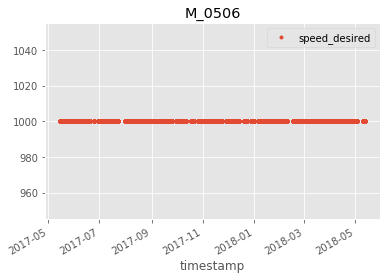

In [21]:
pdf.plot(title=machineID , style=".", y='speed_desired')

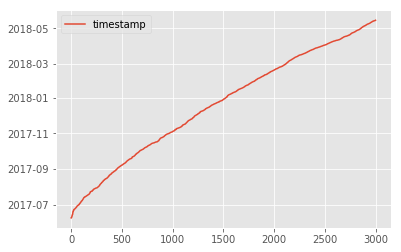

In [22]:
df_logs.toPandas().plot()

## Feature creation

### Operational cycles

275

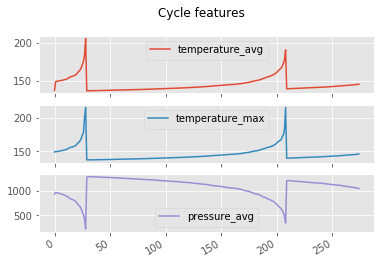

In [23]:
def cycles(df):
    w = Window.partitionBy('machineID').orderBy('timestamp')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(F.unix_timestamp('timestamp') - F.unix_timestamp(F.lag('timestamp', 1).over(w)), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > 30).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.avg('speed').alias('speed_avg'),
        F.avg('temperature').alias('temperature_avg'),
        F.max('temperature').alias('temperature_max'),
        F.avg('pressure').alias('pressure_avg'),
        F.min('timestamp').alias('cycle_start'),
        F.max('timestamp').alias('cycle_end')
    ).orderBy('cycle')

msdf_cycles = cycles(machine_sequence_df)
msdf_cycles[['temperature_avg', 'temperature_max', 'pressure_avg']].toPandas().plot(subplots=True, title='Cycle features')
msdf_cycles.count()

In [24]:
cycles_df = cycles(df_telemetry)
#print(cycles_df.count())

#cycles_df.select(F.max(F.col('cycle_start'))).show()

287540
+-------------------+
|   max(cycle_start)|
+-------------------+
|2018-05-14 15:53:00|
+-------------------+



### Augmenting data with additional lag features

In [25]:
w = Window.partitionBy('machineID').rowsBetween(-5, Window.currentRow).orderBy('cycle_start')
augmented_cycles_df = cycles_df.withColumn('rolling_average', F.avg("temperature_max").over(w))

### Labeling

In [26]:
#df_logs.show()

w = Window.partitionBy('machineID', 'level', 'code').orderBy('timestamp') # since last failure of the same type?
diff = F.coalesce(F.lag('timestamp', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failures_df = (df_logs.where(df_logs.level == 'CRITICAL')
               .withColumn('last_failure_timestamp', diff)
               .withColumnRenamed('timestamp', 'failure_timestamp')
               .withColumnRenamed('code', 'failure')
               .drop('level'))

labeled_cycles_df = (augmented_cycles_df.join(failures_df,
                                       (augmented_cycles_df.machineID == failures_df.machineID) &
                                       (augmented_cycles_df.cycle_start >= failures_df.last_failure_timestamp) &
                                       (augmented_cycles_df.cycle_end <= failures_df.failure_timestamp),
                                       'left_outer')
                     .drop(failures_df.machineID)
                     .drop(augmented_cycles_df.cycle_end)
                     .drop(failures_df.last_failure_timestamp)
                     .withColumnRenamed('cycle_start', 'timestamp')
                     .withColumn(
                         'rul',
                         
                          F.when(F.col('failure').isNull(), None).otherwise(
                             F.row_number().over(Window.partitionBy('machineID', 'failure_timestamp')
                                             .orderBy(F.desc('cycle')))))
                         .drop(failures_df.failure_timestamp))

#labeled_cycles_df.where(F.col('machineID') == 'M_0000').orderBy(F.asc('rul')).toPandas().head()
#failures_df.where(F.col('machineID') == 'M_0000').toPandas().head()
#labeled_cycles_df.where(F.col('machineID') == 'M_0000').count()

,machineID,cycle,speed_avg,temperature_avg,temperature_max,pressure_avg,timestamp,rolling_average,failure,rul
0,M_0000,293,1000.264733,136.982233,137.10,1290.239233,2018-05-13 20:11:00,137.028333,None,NaN
1,M_0000,292,999.873000,136.972667,137.05,1288.624500,2018-05-13 08:18:00,137.000000,None,NaN
2,M_0000,291,999.961167,136.950667,137.04,1292.764000,2018-05-08 23:56:00,136.973333,None,NaN
3,M_0000,290,1000.008250,136.929292,137.03,1291.723333,2018-05-07 19:09:00,136.945000,None,NaN
4,M_0000,289,1000.215200,136.879867,137.00,1294.350033,2018-05-06 09:16:00,136.908333,None,NaN


In [27]:
#labeled_cycles_df.limit(10).toPandas().head()

,machineID,cycle,speed_avg,temperature_avg,temperature_max,pressure_avg,timestamp,rolling_average,failure,rul
0,M_0217,297,1000.222778,139.428833,139.54,1217.466167,2018-05-12 10:01:00,139.425000,None,None
1,M_0217,296,999.863333,139.382750,139.50,1219.387917,2018-05-11 11:54:00,139.380000,None,None
2,M_0217,295,999.983367,139.328100,139.45,1221.655633,2018-05-07 20:12:00,139.336667,None,None
3,M_0217,294,1000.322167,139.283833,139.38,1220.785667,2018-05-07 07:14:00,139.295000,None,None
4,M_0217,293,999.647667,139.245667,139.36,1221.775250,2018-05-06 21:34:00,139.256667,None,None


In [28]:
#labeled_cycles_df.where(labeled_cycles_df.failure.isNotNull()).groupBy('machineID').agg(F.max('rul')).toPandas().describe()

,max(rul)
count,983.000000
mean,170.128179
std,58.991126
min,32.000000
25%,126.000000
50%,170.000000
75%,219.000000
max,289.000000


## Persisting the labeled feature dataset

In [29]:
% rm -rf data/features

labeled_cycles_df.coalesce(5).write.csv('data/features', header=True)

## References
http://waset.org/publications/10006640/building-a-scalable-telemetry-based-multiclass-predictive-maintenance-model-in-r
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.386.8108&rep=rep1&type=pdf